# Using XGBoost

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier, plot_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
data = pd.read_csv("../../files/bank-additional-full.csv", delimiter=";")

In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [4]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Creating the list of columns not necessary
columns_to_drop = [
    "duration",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]

# refining the columns
data = data.drop(columns=columns_to_drop).rename(
    columns={
        "job": "job_type",
        "default": "default_status",
        "housing": "housing_loan_status",
        "loan": "personal_loan_status",
        "contact": "contact_type",
        "month": "contact_month",
        "day_of_week": "contact_day_of_week",
        "campaign": "num_contacts",
        "pdays": "days_last_contact",
        "previous": "previous_contacts",
        "poutcome": "previous_outcome",
        "y": "result",
    }
)

In [6]:
# our target is column result which is categorical
pd.set_option('future.no_silent_downcasting', True)
data["result"] = data["result"].replace({"yes": 1, "no": 0}).astype(int)

In [7]:
data.head()

,age,job_type,marital,education,default_status,housing_loan_status,personal_loan_status,contact_type,contact_month,contact_day_of_week,num_contacts,days_last_contact,previous_contacts,previous_outcome,result
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   job_type              41188 non-null  object
 2   marital               41188 non-null  object
 3   education             41188 non-null  object
 4   default_status        41188 non-null  object
 5   housing_loan_status   41188 non-null  object
 6   personal_loan_status  41188 non-null  object
 7   contact_type          41188 non-null  object
 8   contact_month         41188 non-null  object
 9   contact_day_of_week   41188 non-null  object
 10  num_contacts          41188 non-null  int64 
 11  days_last_contact     41188 non-null  int64 
 12  previous_contacts     41188 non-null  int64 
 13  previous_outcome      41188 non-null  object
 14  result                41188 non-null  int64 
dtypes: int64(5), object(10)
memory usage

In [9]:
data['result'].value_counts()

result
0    36548
1     4640
Name: count, dtype: int64

In [11]:
X = data.drop(columns={"result"})
y = data["result"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=50,
    stratify= y, #"Split the data so that the class distribution of the target variable y remains the same in both the training and testing sets."
)

In [16]:
estimators = [
    ("encoder", TargetEncoder()),
    ("clf", XGBClassifier(random_state=10)),
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

**Setup Hyperparameter** 

In [21]:
search_space = {
    "clf__max_depth": Integer(2, 8),
    "clf__learning_rate": Real(0.001, 1.0, prior="log-uniform"),
    "clf__subsample": Real(0.5, 1.0),
    "clf__colsample_bytree": Real(0.5, 1.0),
    "clf__colsample_bylevel": Real(0.5, 1.0),
    "clf__colsample_bynode": Real(0.5, 1.0),
    "clf__reg_alpha": Real(0.0, 10.0),
    "clf__reg_lambda": Real(0.0, 10.0),
    "clf__gamma": Real(0.0, 10.0),
}

In [22]:
opt = BayesSearchCV(
    pipe, search_space, cv=5, n_iter=10, scoring="roc_auc", random_state=28
)

In [23]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       feature_weights=None,
                                                       gamma=None,
                                                       grow_policy=N...
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [24]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['job_type', 'marital', 'education',
                                     'default_status', 'housing_loan_status',
                                     'personal_loan_status', 'contact_type',
                                     'contact_month', 'contact_day_of_week',
                                     'previous_outcome'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.7096832945964794,
                               colsample_bynode=0.662696576589...
                               gamma=0.651910691808636, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.1472110672698164, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [25]:
opt.best_score_

np.float64(0.7719104023676763)

In [26]:
opt.score(X_test, y_test)

np.float64(0.7746406080475494)

In [27]:
opt.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], shape=(8238,))

In [28]:
opt.predict_proba(X_test)

array([[0.9484285 , 0.05157152],
       [0.85715735, 0.14284268],
       [0.93214   , 0.06785999],
       ...,
       [0.93527406, 0.06472592],
       [0.9647295 , 0.0352705 ],
       [0.92381305, 0.07618696]], shape=(8238, 2), dtype=float32)

In [29]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['job_type', 'marital', 'education', 'default_status',
                      'housing_loan_status', 'personal_loan_status',
                      'contact_type', 'contact_month', 'contact_day_of_week',
                      'previous_outcome'])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.7096832945964794,
                colsample_bynode=0.6626965765899254,
                colsample_bytree=0.6927463744230009, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=0.651910691808636, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1472110672698164,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_ch

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

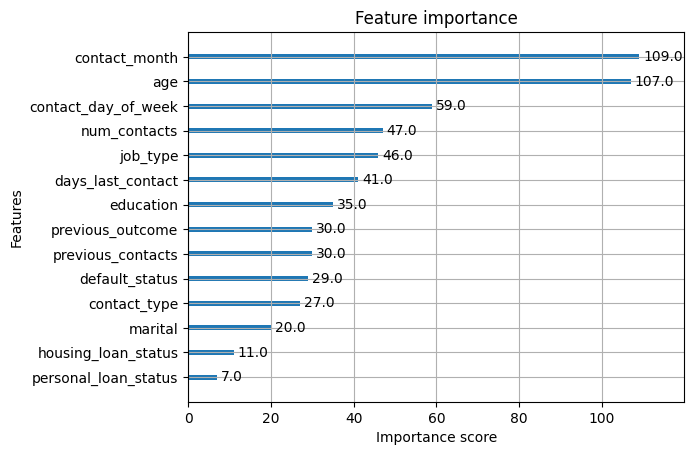

In [30]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)